In [179]:
import pandas as pd
import sys
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Assuming the script is in the 'notebooks' directory and the 'src' directory is at the same level as 'notebooks'
sys.path.append('../src/models')

from isolation_forest import IsolationForestDetector

In [180]:
df1 = pd.read_csv('../data/anomaly_detection_01.csv')
df2 = pd.read_csv('../data/anomaly_detection_02.csv')

rename_cols = {
    'Date': 'datetime',
    'Value': 'motor_current'
}

df1 = df1.rename(columns=rename_cols)
df2 = df2.rename(columns=rename_cols)

In [181]:
df1['datetime'] = pd.to_datetime(df1['datetime'])
df2['datetime'] = pd.to_datetime(df2['datetime'])

df1["date"] = pd.to_datetime(df1["datetime"].dt.date)
df2["date"] = pd.to_datetime(df2["datetime"].dt.date)

In [182]:
df1['datetime'] = pd.to_datetime(df1['datetime'])
df1 = df1.set_index('datetime')
df1 = df1.sort_index()

df2['datetime'] = pd.to_datetime(df2['datetime'])
df2 = df2.set_index('datetime')
df2 = df2.sort_index()

## Visual Overview

<Axes: xlabel='date'>

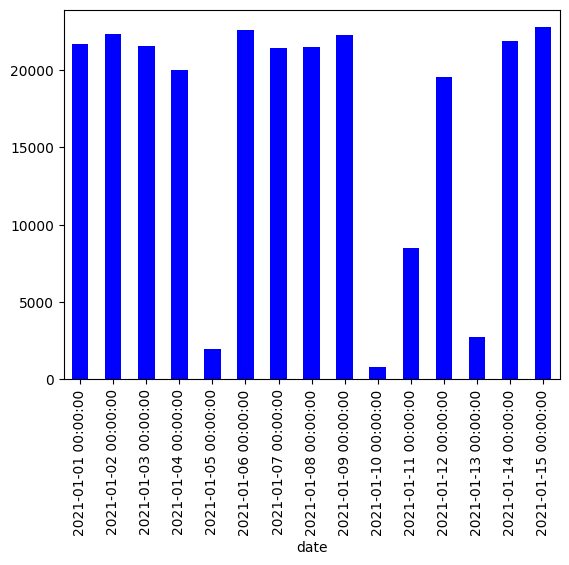

In [183]:
df1["date"].value_counts().sort_index().plot(kind='bar', color='blue')

<Axes: xlabel='date'>

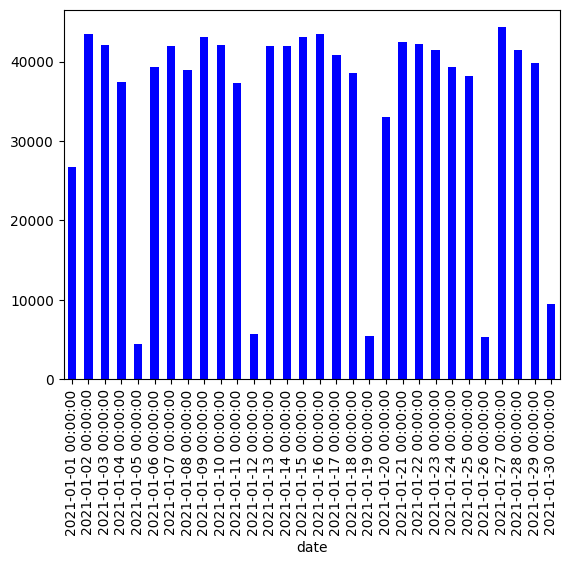

In [184]:
df2["date"].value_counts().sort_index().plot(kind='bar', color='blue')

In [185]:
def plot_resamplings(df, column='motor_current'):
    df[column].plot(title='Original Data')
    plt.show()

    df[column].resample('min').mean().plot(title='Minute Resampling')
    plt.show()

    df[column].resample('h').mean().plot(title='Hourly Resampling')
    plt.show()

    df[column].resample('D').mean().plot(title='Daily Resampling')
    plt.show()

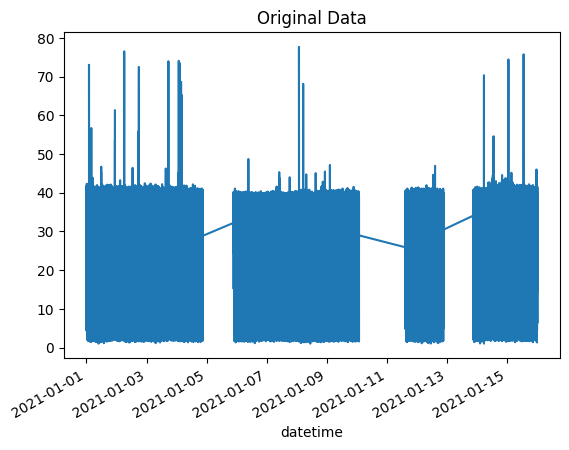

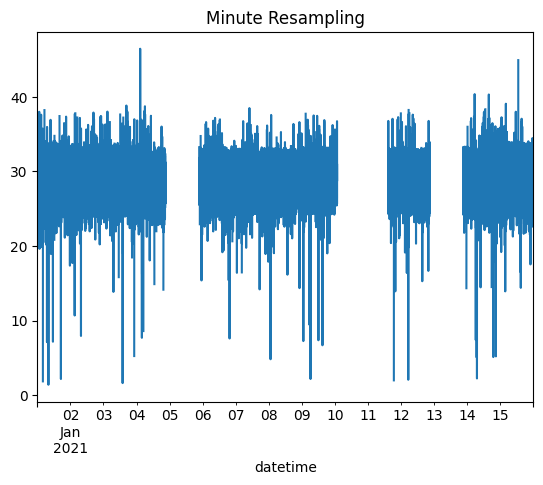

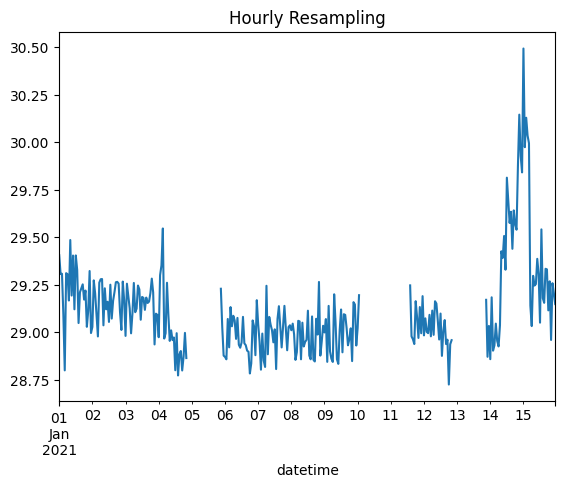

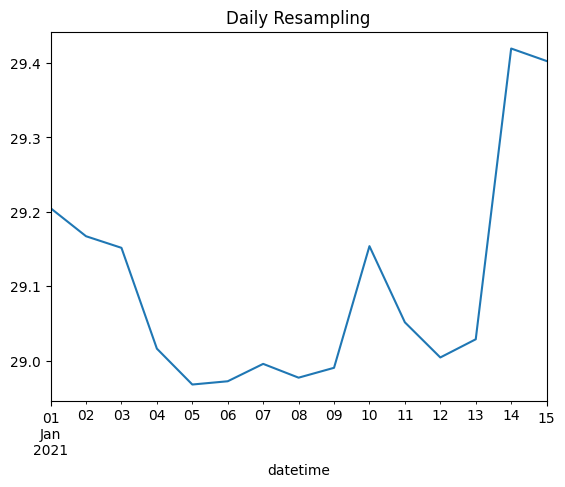

In [186]:
# TODO: wisualize the new features as well like MA, STD, etc.
# hourly, daily, weekly, monthly, yearly resampling and visualization

plot_resamplings(df1)


- There are dates where we dont have any data.
- Even thought original data and minutely resampling does not represent the anomlaies, we can see the anomalies on day 14th in hourly resampling and daily resampling.

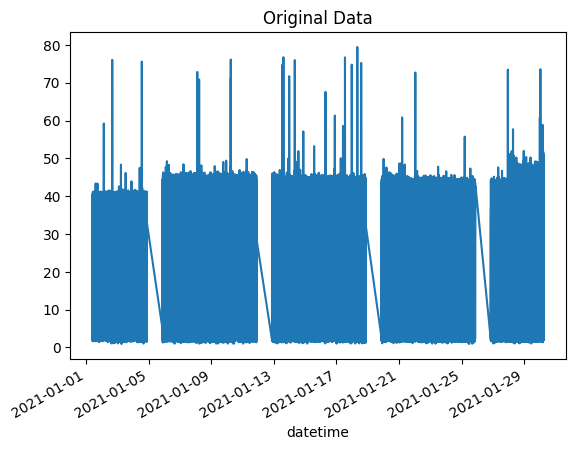

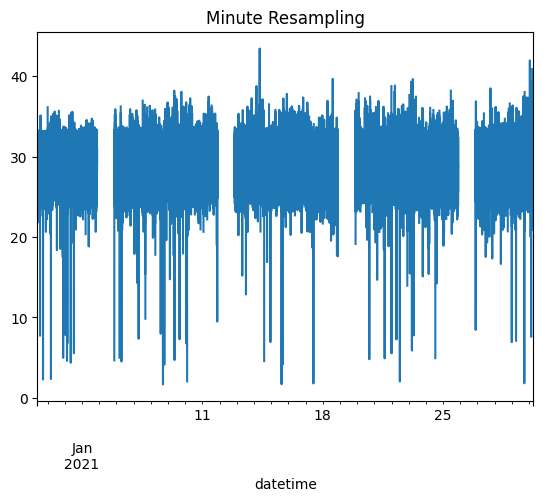

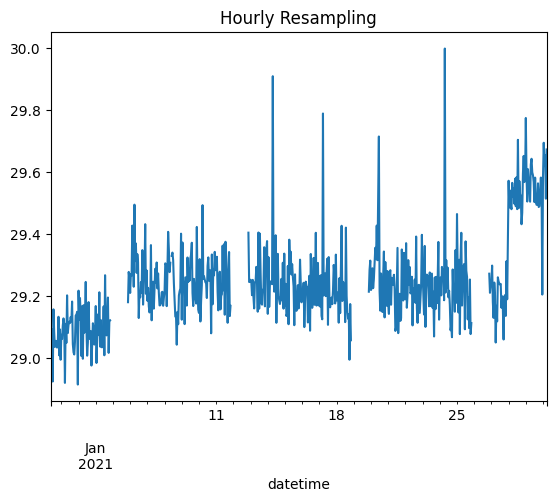

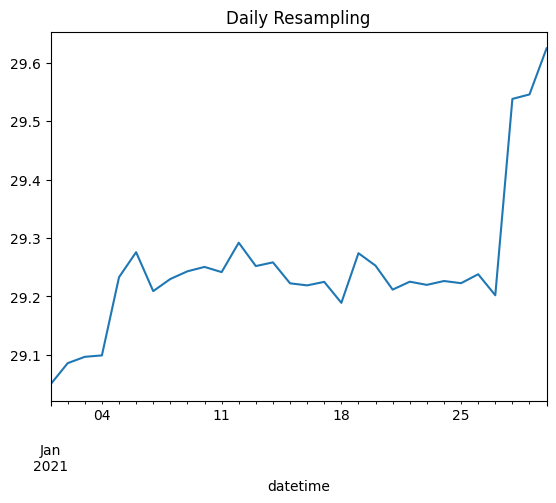

In [187]:
# TODO: wisualize the new features as well like MA, STD, etc.
# TODO: investigate the empty dates (are they weekend?)
# hourly, daily, weekly, monthly, yearly resampling and visualization

plot_resamplings(df2)

## Use of Matrix Profiling

- STUMPY is a powerful and scalable library that efficiently computes something called the matrix profile, which can be used for a variety of time series data mining tasks such as anomaly discovery.

## Feature Engineering

In [188]:
def extract_datetime_features(df):
    df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
    df['day_sin'] = np.sin(2 * np.pi * df.index.day / 31)
    df['day_cos'] = np.cos(2 * np.pi * df.index.day / 31)
    df['weekday_sin'] = np.sin(2 * np.pi * df.index.weekday / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df.index.weekday / 7)
    return df

#df1 = extract_datetime_features(df1)
df1


,motor_current,date
datetime,,
2021-01-01 00:01:15,7.419254,2021-01-01
2021-01-01 00:01:16,40.993702,2021-01-01
2021-01-01 00:01:17,38.593835,2021-01-01
2021-01-01 00:01:18,38.429304,2021-01-01
2021-01-01 00:01:19,37.370117,2021-01-01
...,...,...
2021-01-15 23:59:41,25.186163,2021-01-15
2021-01-15 23:59:42,25.338068,2021-01-15
2021-01-15 23:59:43,25.725825,2021-01-15


In [189]:
def extract_datetime_features(df):
    #df["minute"] = df.index.minute
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['weekday'] = df.index.weekday
    return df

#df1 = extract_datetime_features(df1)
df1

,motor_current,date
datetime,,
2021-01-01 00:01:15,7.419254,2021-01-01
2021-01-01 00:01:16,40.993702,2021-01-01
2021-01-01 00:01:17,38.593835,2021-01-01
2021-01-01 00:01:18,38.429304,2021-01-01
2021-01-01 00:01:19,37.370117,2021-01-01
...,...,...
2021-01-15 23:59:41,25.186163,2021-01-15
2021-01-15 23:59:42,25.338068,2021-01-15
2021-01-15 23:59:43,25.725825,2021-01-15


In [190]:
# feature engineering: Derive additional features (e.g., moving averages, rolling standard deviations, Fourier transforms

def extract_statistical_features(df, column='motor_current'):
    # moving average
    df['MA'] = df[column].rolling(window=60*20).mean()

    # rolling standard deviation
    df['STD'] = df[column].rolling(window=60*20).std()

    # Fourier transform, use numpy
    df['FT'] = np.fft.fft(df[column])
    # convert complex numbers to real numbers
    df['FT'] = df['FT'].apply(lambda x: np.abs(x))

    return df

df1 = extract_statistical_features(df1)
df1

,motor_current,date,MA,STD,FT
datetime,,,,,
2021-01-01 00:01:15,7.419254,2021-01-01,NaN,NaN,7.325107e+06
2021-01-01 00:01:16,40.993702,2021-01-01,NaN,NaN,2.414634e+04
2021-01-01 00:01:17,38.593835,2021-01-01,NaN,NaN,9.300681e+03
2021-01-01 00:01:18,38.429304,2021-01-01,NaN,NaN,1.361573e+04
2021-01-01 00:01:19,37.370117,2021-01-01,NaN,NaN,1.086367e+04
...,...,...,...,...,...
2021-01-15 23:59:41,25.186163,2021-01-15,29.219226,5.934531,1.043747e+04
2021-01-15 23:59:42,25.338068,2021-01-15,29.216205,5.935584,1.086367e+04
2021-01-15 23:59:43,25.725825,2021-01-15,29.213868,5.936406,1.361573e+04


In [191]:
split1_date = pd.to_datetime("2021-01-08")
split2_date = pd.to_datetime("2021-01-13")
df1_normal = df1[df1["date"]<split1_date] # for training
df1_normal_test = df1[(df1["date"]>=split1_date) & (df1["date"]<split2_date)] # for testing normal data
df1_anormal = df1[df1["date"]>=split2_date] # for testing anormal data

In [192]:
split1_date = pd.to_datetime("2021-01-25")
split2_date = pd.to_datetime("2021-01-28")
df2_normal = df2[df2["date"]<split1_date] # for training
df2_normal_test = df2[(df2["date"]>=split1_date) & (df2["date"]<split2_date)] # for testing normal data
df2_anormal = df2[df2["date"]>=split2_date] # for testing anormal data

In [193]:
# merge dfs
# df_normal = pd.concat([df1_normal, df2_normal])
# df_normal_test = pd.concat([df1_normal_test, df2_normal_test])
# df_anormal = pd.concat([df1_anormal, df2_anormal])

# df_normal = df1_normal
# df_normal_test = df1_normal_test
# df_anormal = df1_anormal

df_normal = df2_normal
df_normal_test = df2_normal_test
df_anormal = df2_anormal

In [194]:
df1_normal

,motor_current,date,MA,STD,FT
datetime,,,,,
2021-01-01 00:01:15,7.419254,2021-01-01,NaN,NaN,7.325107e+06
2021-01-01 00:01:16,40.993702,2021-01-01,NaN,NaN,2.414634e+04
2021-01-01 00:01:17,38.593835,2021-01-01,NaN,NaN,9.300681e+03
2021-01-01 00:01:18,38.429304,2021-01-01,NaN,NaN,1.361573e+04
2021-01-01 00:01:19,37.370117,2021-01-01,NaN,NaN,1.086367e+04
...,...,...,...,...,...
2021-01-07 23:59:55,25.350398,2021-01-07,29.067580,5.460839,1.353485e+03
2021-01-07 23:59:56,25.674823,2021-01-07,29.061082,5.460232,2.121991e+03
2021-01-07 23:59:57,26.118710,2021-01-07,29.050502,5.453614,1.583375e+03


In [195]:
# train normal set on isolation forest
params = {
    "n_estimators": 100,
    "max_samples": "auto",
    "contamination": "auto", # 0.15
    "max_features": 1.0,
    "bootstrap": True,
    "n_jobs": -1,
    "random_state": 42,
    "verbose": 1,
}
clf = IsolationForestDetector(**params)
clf.fit(df_normal.drop(columns=["date"]))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s


In [196]:
clf.threshold

-0.497305275081842

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


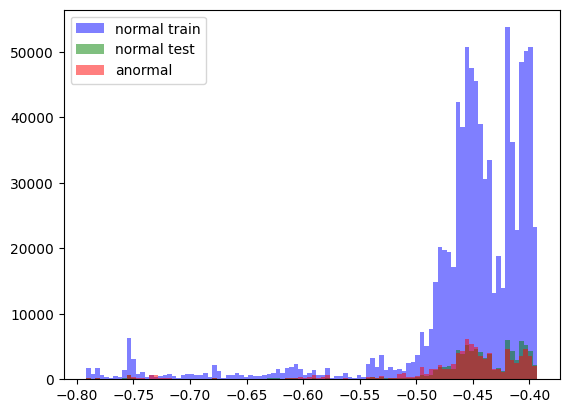

In [197]:
normal_train_scores = clf.score_samples(df_normal.drop(columns=["date"]))
normal_test_scores = clf.score_samples(df_normal_test.drop(columns=["date"]))
anormal_scores = clf.score_samples(df_anormal.drop(columns=["date"]))

# plot all
plt.figure()
plt.hist(normal_train_scores, bins=100, color='blue', alpha=0.5, label='normal train')
plt.hist(normal_test_scores, bins=100, color='green', alpha=0.5, label='normal test')
plt.hist(anormal_scores, bins=100, color='red', alpha=0.5, label='anormal')
plt.legend()
plt.show()

In [198]:
clf.threshold

-0.497305275081842

In [199]:
normal_train_scores

array([-0.4345062 , -0.53113781, -0.40814412, ..., -0.41787794,
       -0.41915391, -0.49685593])

In [200]:
# train results
normal_train_preds = clf.predict(df_normal.drop(columns=["date"]))

normal_test_preds = clf.predict(df_normal_test.drop(columns=["date"]))

anormal_test_preds = clf.predict(df_anormal.drop(columns=["date"]))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


In [201]:
# print and calculate the value counts of numpy preds
print("Normal train preds:")
print(pd.Series(normal_train_preds).value_counts())
print("Normal test preds:")
print(pd.Series(normal_test_preds).value_counts())
print("Anormal test preds:")
print(pd.Series(anormal_test_preds).value_counts())


Normal train preds:
0    770757
1     85640
Name: count, dtype: int64
Normal test preds:
0    79147
1     8618
Name: count, dtype: int64
Anormal test preds:
0    76965
1    13846
Name: count, dtype: int64


In [202]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    return accuracy, precision, recall, f1, auc

In [203]:
# calculate metrics

# concat normal and anormal test preds
test_preds = np.concatenate([normal_test_preds, anormal_test_preds])
test_targets = np.concatenate([np.zeros(len(normal_test_preds), dtype=int), np.ones(len(anormal_test_preds), dtype=int)])

accuracy, precision, recall, f1, auc = calculate_metrics(test_targets, test_preds)

print(f" Accuracy: {accuracy} \n Precision: {precision} \n Recall: {recall} \n F1: {f1} \n AUC: {auc}")

 Accuracy: 0.5207474688647971 
 Precision: 0.6163639601139601 
 Recall: 0.15247051568642564 
 F1: 0.24446700507614214 
 AUC: 0.5271382373908685


In [204]:
# calculate the performance
from sklearn.metrics import confusion_matrix
df1_normal_test["Target"] = 0
df1_anormal["Target"] = 1
df1_test = pd.concat([df1_normal_test, df1_anormal])
confusion_matrix(df1_test["Target"], df1_test["Anomaly"])

# extract tp, fp, tn, fn
tn, fp, fn, tp = confusion_matrix(df1_test["Target"], df1_test["Anomaly"]).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f_score = 2*tp/(2*tp+fp+fn)

accuracy = (tp+tn)/(tp+tn+fp+fn)

auc_score = (tp/(tp+fn) + tn/(tn+fp))/2 # ??

print("tp:", tp, "fp:", fp, "tn:", tn, "fn:", fn, "accuracy:", accuracy, "precision:", precision, "recall:", recall, "f_score:", f_score, "auc_score:", auc_score)

/var/folders/34/1qrznjy966vdc3s1xrx1qb500000gn/T/ipykernel_79405/44623452.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_normal_test["Target"] = 0
/var/folders/34/1qrznjy966vdc3s1xrx1qb500000gn/T/ipykernel_79405/44623452.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_anormal["Target"] = 1


KeyError: 'Anomaly'

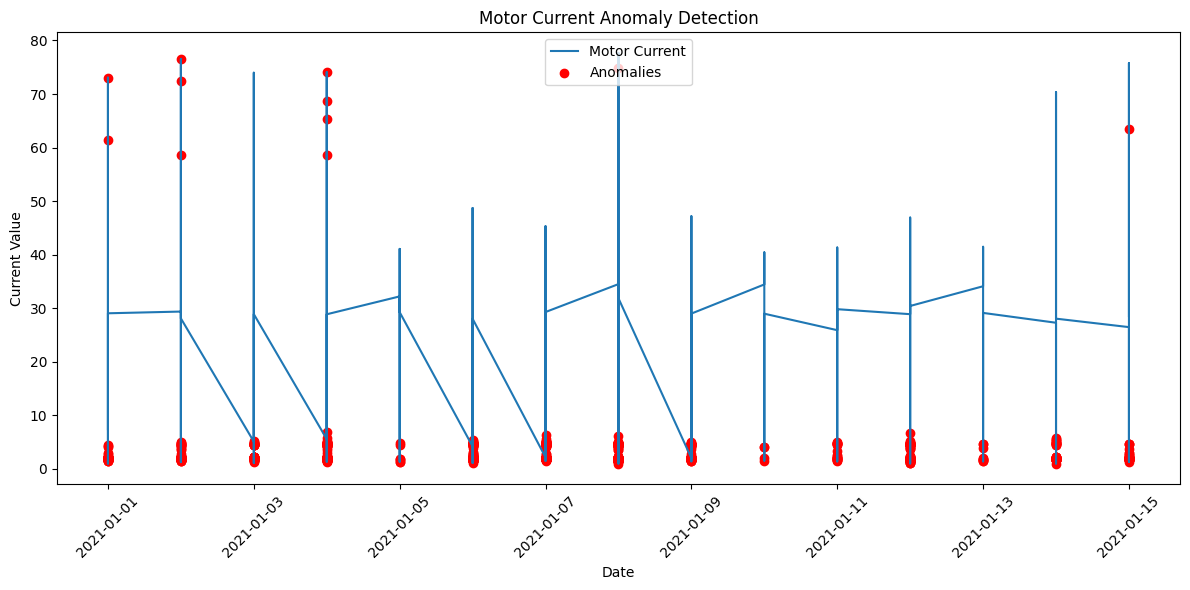

Anomaly Summary:
Total Anomalies Detected: 862

Anomalies Details:
                          date  motor_current   Z_Score
datetime                                               
2021-01-01 00:42:16 2021-01-01       1.976226 -4.194995
2021-01-01 02:04:48 2021-01-01       2.056041 -4.192718
2021-01-01 02:04:49 2021-01-01      73.058928  4.341762
2021-01-01 02:27:32 2021-01-01       1.653858 -4.037620
2021-01-01 02:57:25 2021-01-01       1.861163 -4.174840
...                        ...            ...       ...
2021-01-15 20:27:21 2021-01-15       1.361589 -4.056296
2021-01-15 20:38:35 2021-01-15       1.817994 -4.228107
2021-01-15 20:44:24 2021-01-15       2.020468 -4.190168
2021-01-15 22:24:00 2021-01-15       1.939249 -4.084039
2021-01-15 22:44:13 2021-01-15       3.733551 -4.000814

[862 rows x 3 columns]

Pre-Failure Anomaly Analysis:
Days before failure with anomalies: 1
First anomaly detected: 2021-01-01 00:00:00
Last anomaly before failure: 2021-01-14 00:00:00


KeyError: 'Value'

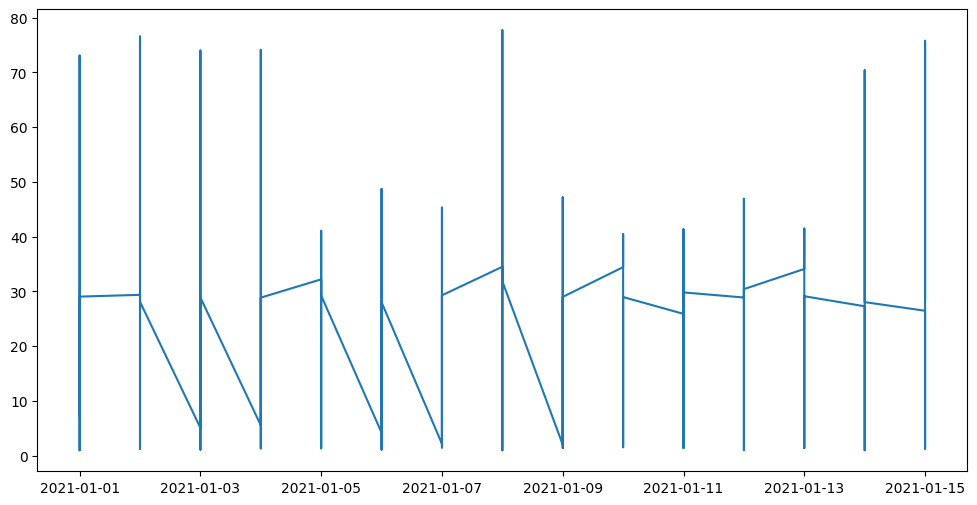

In [488]:
# Anomaly Detection Function
def detect_anomalies(data, window_size=30, sigma_threshold=4):
    # Calculate rolling mean and standard deviation
    rolling_mean = data['motor_current'].rolling(window=window_size).mean()
    rolling_std = data['motor_current'].rolling(window=window_size).std()
    
    # Calculate Z-scores
    z_scores = (data['motor_current'] - rolling_mean) / rolling_std
    
    # Identify anomalies
    anomalies = np.abs(z_scores) > sigma_threshold
    
    return anomalies, z_scores

# Detect anomalies
anomalies, z_scores = detect_anomalies(df1)

# Prepare anomaly results
df1['Anomaly'] = anomalies
df1['Z_Score'] = z_scores

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(df1['date'], df1['motor_current'], label='Motor Current')
plt.scatter(df1[df1['Anomaly']]['date'], df1[df1['Anomaly']]['motor_current'], 
            color='red', label='Anomalies')
plt.title('Motor Current Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Current Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Anomaly Summary
print("Anomaly Summary:")
print(f"Total Anomalies Detected: {anomalies.sum()}")
print("\nAnomalies Details:")
print(df1[df1['Anomaly']][['date', 'motor_current', 'Z_Score']])

# Time to Failure Analysis
def time_to_failure_analysis(df, failure_date):
    # Detect anomalies
    df['Anomaly'], df['Z_Score'] = detect_anomalies(df)
    
    # Filter anomalies before failure date
    pre_failure_anomalies = df[(df['Anomaly']) & (df['date'] < failure_date)]
    
    print("\nPre-Failure Anomaly Analysis:")
    if not pre_failure_anomalies.empty:
        print(f"Days before failure with anomalies: {(failure_date - pre_failure_anomalies['date'].max()).days}")
        print("First anomaly detected:", pre_failure_anomalies['date'].min())
        print("Last anomaly before failure:", pre_failure_anomalies['date'].max())
    else:
        print("No anomalies detected before the failure date.")

# Visualization
def plot_anomalies(df, failure_date):
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['motor_current'], label='Motor Current')
    plt.scatter(df[df['Anomaly']]['date'], df[df['Anomaly']]['Value'], 
                color='red', label='Anomalies')
    plt.axvline(x=failure_date, color='green', linestyle='--', label='Failure Date')
    plt.title('Motor Current Anomaly Detection')
    plt.xlabel('date')
    plt.ylabel('Current Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

failure_date = pd.to_datetime('2021-01-15')
time_to_failure_analysis(df1, failure_date)

plot_anomalies(df1, failure_date)